### **Code for Plotting American Option Binomial Trees** 

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

def plot_amer_binomial_option_tree(S0, u, d, result_dict, title="American Option Price Tree"):
    """
    Plot an American option tree showing where early exercise occurs.
    Includes a legend explaining the colour coding.
    
    Parameters
    ----------
    S0 : float
        Initial stock price.
    u : float
        Upward movement factor.
    d : float
        Downward movement factor.
    result_dict : dict
        Output from amer_binomial_option_price(), must contain 'option_tree' and 'exercise_flags'.
    title : str
        Plot title.
    """
    option_tree = result_dict["option_tree"]
    flags = result_dict["exercise_flags"]
    N = len(option_tree) - 1
    C0 = option_tree[0][0]
    
    # Build stock price tree
    price_tree = [[S0 * (u**j) * (d**(i - j)) for j in range(i + 1)] for i in range(N + 1)]
    
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=14, fontweight="bold")
    plt.axis("off")
    x_spacing, y_spacing = 1.0, 1.0
    
    for i, level in enumerate(price_tree):
        for j, price in enumerate(level):
            x = i * x_spacing
            y = j * y_spacing - (i * y_spacing / 2)
            opt_val = option_tree[i][j]
            exercised = flags[i][j]

            # Colour rule
            if exercised:
                color = "seagreen"       # early exercise
            else:
                color = "dodgerblue" if opt_val >= C0 else "indianred"
            
            # Connect nodes
            if i < N:
                plt.plot([x, x + x_spacing],
                         [y, j * y_spacing - ((i + 1) * y_spacing / 2)],
                         color="gray", linewidth=1)
                plt.plot([x, x + x_spacing],
                         [y, (j + 1) * y_spacing - ((i + 1) * y_spacing / 2)],
                         color="gray", linewidth=1)
            
            # Draw node
            label = f"{price:.2f}\n({opt_val:.2f})"
            plt.scatter(x, y, color=color, s=250, zorder=3, edgecolor="black")
            plt.text(x, y, label, fontsize=8, ha="center", va="center", color="white",
                     bbox=dict(boxstyle="round,pad=0.3", fc=color, ec="none", alpha=0.9))
    
    # Add colour legend
    legend_patches = [
        mpatches.Patch(color="seagreen", label="Early Exercise"),
        mpatches.Patch(color="dodgerblue", label="Continuation (≥ C₀)"),
        mpatches.Patch(color="indianred", label="Continuation (< C₀)")
    ]
    plt.legend(handles=legend_patches, loc="upper left", frameon=False, fontsize=9)
    
    plt.tight_layout()
    plt.show()


### **American Option Multi-Step (N-Step) Binomial Model**

In [16]:
import math

def amer_binomial_option_price(S0, E, r, T, u, d, N, option_type="call"):
    """Price an American option using an N-step binomial tree and return exercise flags."""
    dt = T / N
    p = (math.exp(r * dt) - d) / (u - d)

    # Stock prices at maturity
    prices = [S0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]

    # Option payoffs at maturity
    if option_type == "call":
        values = [max(price - E, 0) for price in prices]
    else:
        values = [max(E - price, 0) for price in prices]

    option_tree = [values]
    exercise_flags = [[False for _ in values]]  # same shape, marks early exercise

    # Work backwards
    for i in range(N - 1, -1, -1):
        prices = [S0 * (u ** j) * (d ** (i - j)) for j in range(i + 1)]
        new_values = []
        new_flags = []

        for j in range(i + 1):
            cont_val = math.exp(-r * dt) * (p * option_tree[0][j + 1] + (1 - p) * option_tree[0][j])
            if option_type == "call":
                exercise_val = max(prices[j] - E, 0)
            else:
                exercise_val = max(E - prices[j], 0)

            # Early exercise check
            if exercise_val > cont_val:
                new_values.append(exercise_val)
                new_flags.append(True)
            else:
                new_values.append(cont_val)
                new_flags.append(False)

        option_tree.insert(0, new_values)
        exercise_flags.insert(0, new_flags)

    return {
        "p": round(p, 5),
        "option_tree": option_tree,
        "exercise_flags": exercise_flags,
        "option_price": round(option_tree[0][0], 3)
    }


Risk-neutral p: 0.54202
Option price: 6.999


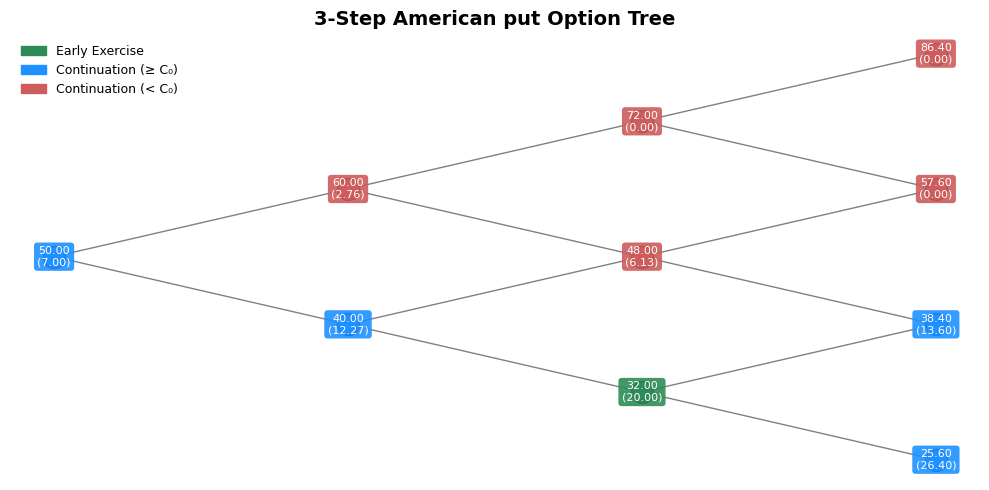

In [18]:
S0, E, r, T, u, d, N , option_type = 50, 52, 0.05, 1, 1.2, 0.8, 3 , "put"
result = (amer_binomial_option_price(S0, E, r, T, u, d, N, option_type))

print("Risk-neutral p:", result["p"])
print("Option price:", result["option_price"])

plot_amer_binomial_option_tree(S0=50, u=1.2, d=0.8, result_dict=result,
                               title=str(N) + "-Step American " + option_type +" Option Tree")
